In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, auc, roc_curve, accuracy_score
from sklearn.metrics import roc_curve, auc as calc_auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense

import xgboost as xgb

In [2]:
# Identificación de outliers utilizando el rango intercuartil (IQR)
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


#Función para calcular la rentabilidad de los modelos con mejor ROC
def calcular_rentabilidad(model, X_test, y_test):
    # Obtener las predicciones y la matriz de confusión
    predicciones = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predicciones).ravel()

    # Calcular la rentabilidad
    rentabilidad = (tp + tn) * 100 - fp * 20 - fn * 500
    return rentabilidad

## EDA

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [4]:
df.shape

(12330, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Vamos a ver información de las variables, su distribución, de qué tipo son, etc...

In [6]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [7]:
num_feat = df.select_dtypes(include=['int64', 'float64']).columns
cat_feat = df.select_dtypes(include=['object']).columns
bool_feat = df.select_dtypes(include=['bool']).columns

# Vemos la cantidad de variables de cada tipo
print('Número de variables Numéricas: ', len(num_feat))
print('Número de variables Categóricas: ', len(cat_feat))
print('Número de variables Categóricas: ', len(bool_feat))

Número de variables Numéricas:  14
Número de variables Categóricas:  2
Número de variables Categóricas:  2


In [8]:
print(df[num_feat].columns)
print(df[cat_feat].columns)
print(df[bool_feat].columns)

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')
Index(['Month', 'VisitorType'], dtype='object')
Index(['Weekend', 'Revenue'], dtype='object')


In [9]:
df[num_feat].describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


- Valores Negativos: Notablemente, algunas columnas como Administrative_Duration, Informational_Duration, y ProductRelated_Duration tienen valores mínimos de -1, lo cual es inusual y podría indicar datos erróneos o valores de marcador.
- Distribución de las Variables: Las diferencias entre el promedio (mean) y la mediana (50%) en algunas columnas sugieren distribuciones sesgadas. Por ejemplo, ProductRelated y ProductRelated_Duration tienen medias significativamente más altas que sus medianas, lo que indica una distribución con cola larga hacia valores más altos.
- Valores Atípicos: Valores máximos muy altos en comparación con el 75% percentil en columnas como Administrative_Duration, Informational_Duration, ProductRelated, y ProductRelated_Duration sugieren la presencia de valores atípicos.

Se puede ver que en las primeras categorias faltan registros, 14 para ser exactos

In [10]:
df[cat_feat].describe()

,Month,VisitorType
count,12330,12330
unique,10,3
top,May,Returning_Visitor
freq,3364,10551


In [11]:
df[bool_feat].describe()

,Weekend,Revenue
count,12330,12330
unique,2,2
top,False,False
freq,9462,10422



- top: Es el valor más frecuente en la columna. Para Weekend, el valor más común es False, y para Revenue, también es False. Esto significa que, en la mayoría de las sesiones, los clientes no estaban navegando en el sitio web durante el fin de semana y la mayoría de las sesiones no resultaron en ingresos (es decir, en compras).
- freq: Indica la frecuencia del valor más común (top). En Weekend, False aparece 9,462 veces, lo que significa que en la mayoría de las sesiones los clientes no estaban en el sitio durante el fin de semana. En Revenue, False aparece 10,422 veces, lo que indica que en la mayoría de las sesiones, no se generaron ingresos. Supongo que este es un warning para la empresa y que se deben sacar conclusiones para poder mejorar estas cifras.

In [12]:
# Convertir las variables booleanas a numéricas
df[bool_feat] = df[bool_feat].astype(int)
df

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,1,0
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,1,0
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,1,0
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,0,0


Antes de comenzar a hacer gráficos, vamos a ver en detalle la cantidad de datos faltantes en nuestro set. Para ello, utilizaremos el método isnull de Pandas y veremos el total de valores nulos y el porcentaje que simboliza:

In [13]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
data_null = pd.concat([total, percent], axis=1, keys=['total', 'percent'])
data_null

,total,percent
Administrative,14,0.001135
Informational,14,0.001135
Informational_Duration,14,0.001135
ProductRelated,14,0.001135
ProductRelated_Duration,14,0.001135
BounceRates,14,0.001135
ExitRates,14,0.001135
Administrative_Duration,14,0.001135
Region,0,0.000000
Weekend,0,0.000000


In [14]:
# Filtrando las filas donde hay al menos un valor nulo
rows_with_null = df[df.isnull().any(axis=1)]
rows_with_null

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,0,0
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,0,0
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,0,0
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,0,0
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,0,0
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,1,0
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,1,0
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,0,0
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,0,0


Se ve que la mayoría de nulos son en el mes de marzo y solo uno en mayo. No se exactamente el por qué, pero parece que al estar concentrado en ese mes hubo algún fallo o cambio a la hora de registrar los datos en ese periodo.

In [15]:
df_clean = df.dropna()

Viendo que solo hay 14 filas con nulos, que se concentran en marzo y que no encuentro una evidencia o problema del por qué, las elimino para seguir con otros pasos

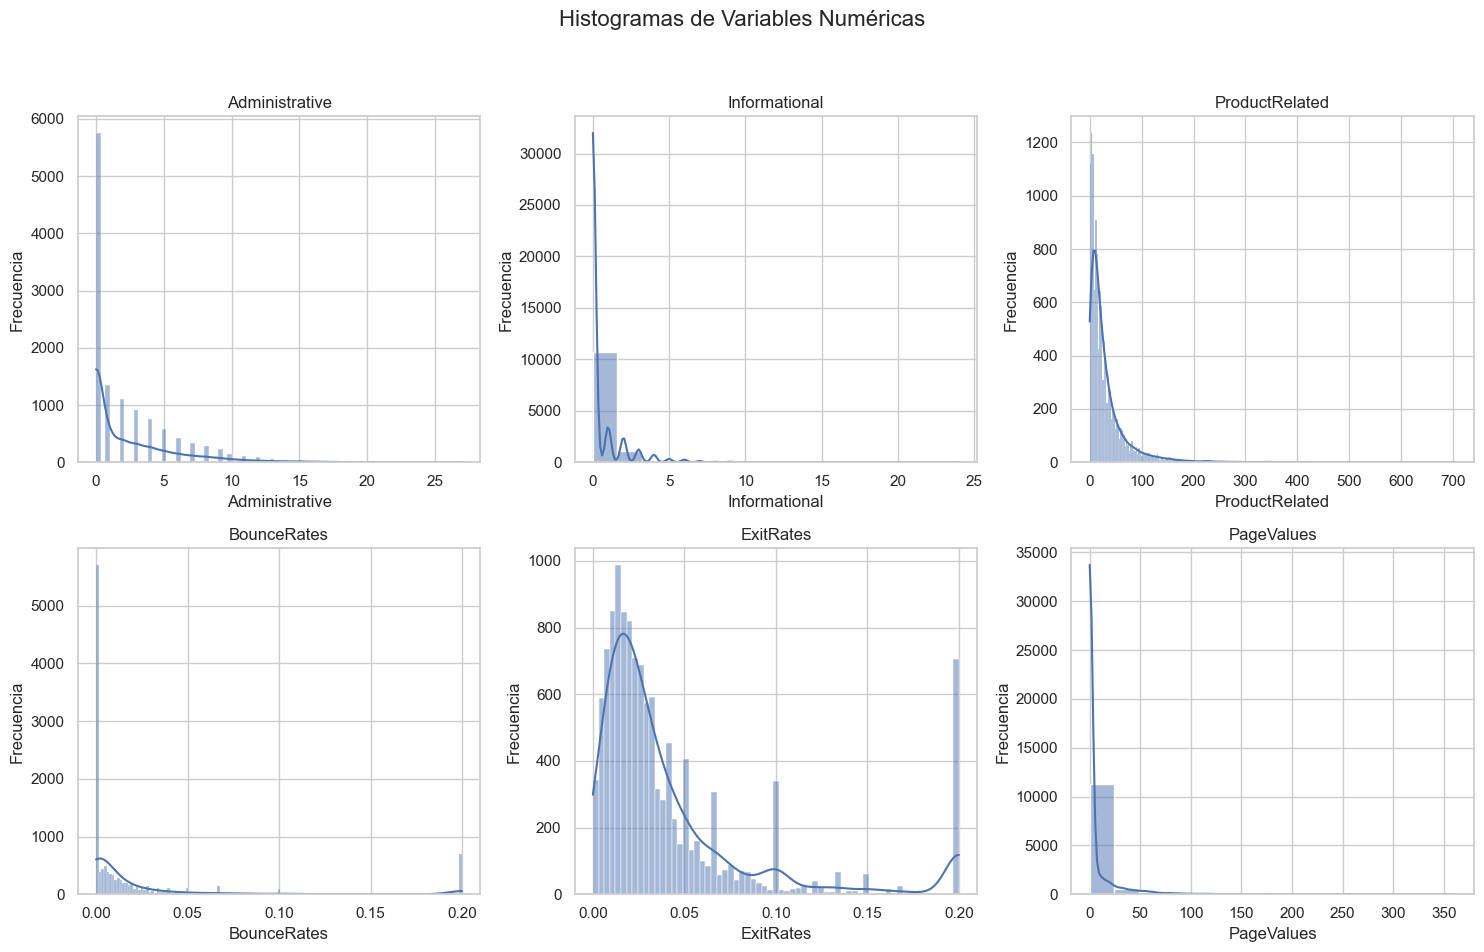

In [16]:
sns.set(style="whitegrid")

# Seleccionamos algunas variables numéricas para el análisis
num_variables_to_analyze = ['Administrative', 'Informational', 'ProductRelated', 
                            'BounceRates', 'ExitRates', 'PageValues']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Histogramas de Variables Numéricas', fontsize=16)

for i, col in enumerate(num_variables_to_analyze):
    ax = axes[i//3, i%3]
    sns.histplot(df_clean[col], ax=ax, kde=True)
    ax.set_title(col)
    ax.set_ylabel('Frecuencia')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Histogramas de Variables Numéricas

- Administrative: La mayoría de las sesiones tienen un bajo número de visitas a páginas administrativas.
- Informational: Similar a 'Administrative', la mayoría de las sesiones tienen pocas o ninguna visita a páginas informativas.
- ProductRelated: Esta variable muestra una distribución más amplia, indicando variaciones más significativas en el número de páginas de productos visitadas por sesión.
- BounceRates: La mayoría de las sesiones tienen tasas de rebote bajas, lo que sugiere que los usuarios suelen interactuar con más de una página.
- ExitRates: Al igual que 'BounceRates', las tasas de salida son generalmente bajas, pero con una distribución más amplia.
- PageValues: La mayoría de las sesiones tienen valores de página bajos, con solo unas pocas sesiones mostrando valores altos.

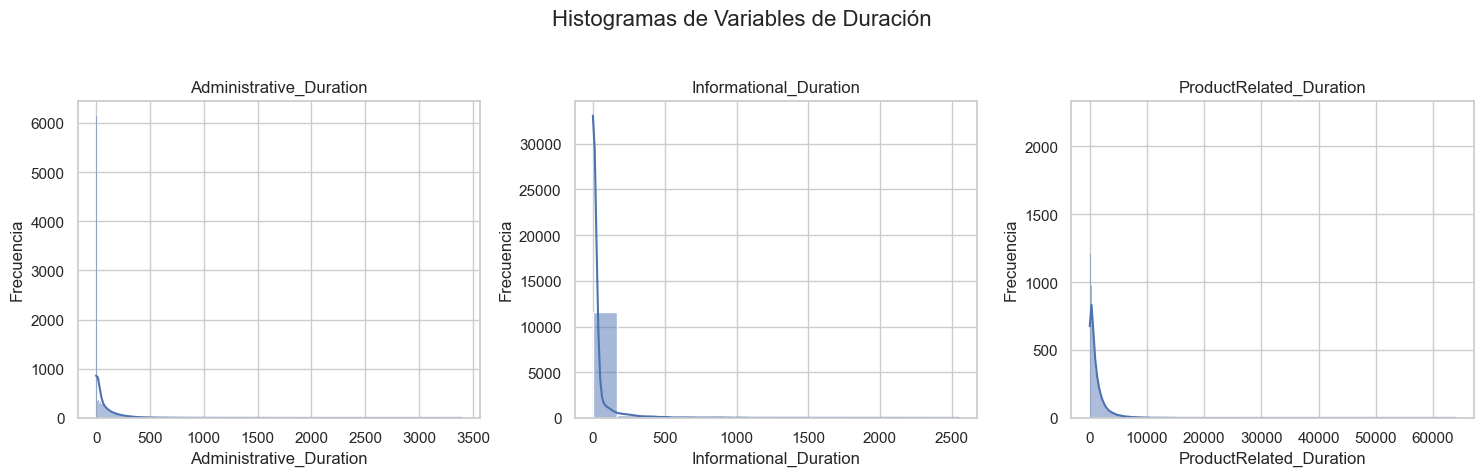

In [17]:
# Seleccionamos las variables de duración para el análisis
duration_variables = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Histogramas de Variables de Duración', fontsize=16)

for i, col in enumerate(duration_variables):
    ax = axes[i]
    sns.histplot(df_clean[col], ax=ax, kde=True)
    ax.set_title(col)
    ax.set_ylabel('Frecuencia')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Histogramas de Variables de Duración

- Administrative_Duration: La mayoría de las sesiones tienen una duración administrativa baja, con solo unas pocas sesiones mostrando tiempos altos.
- Informational_Duration: Similar a 'Administrative_Duration', la duración en páginas informativas es generalmente baja, lo que sugiere que los usuarios pasan menos tiempo en estas páginas.
- ProductRelated_Duration: Esta variable muestra una distribución más amplia, indicando que hay más variación en el tiempo que los visitantes pasan en páginas relacionadas con productos.

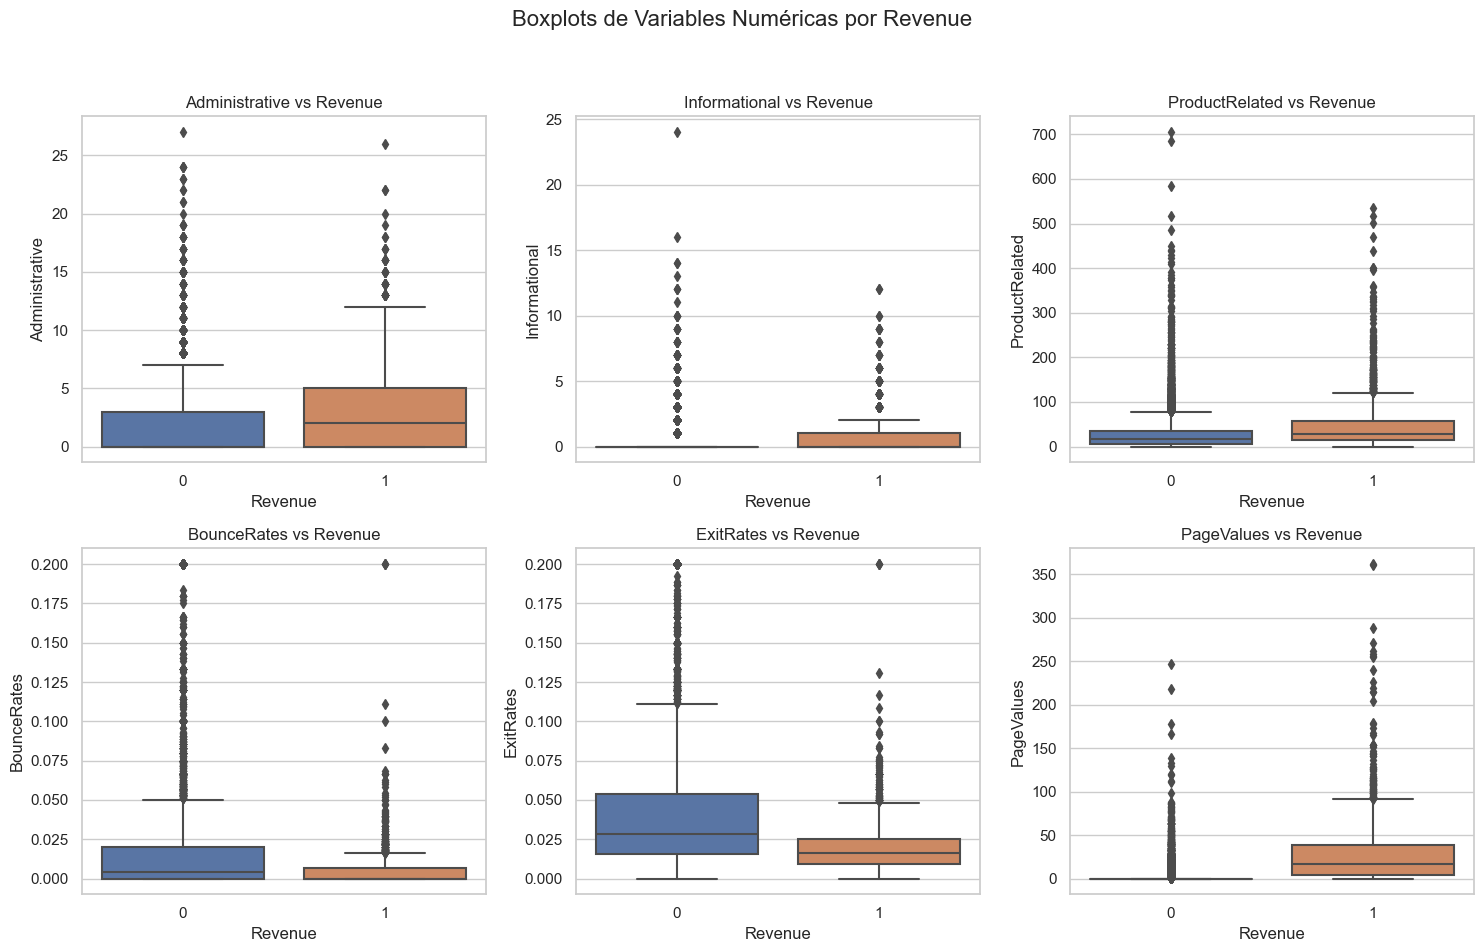

In [18]:
# Creamos boxplots para las mismas variables, pero en relación a la variable objetivo "Revenue"
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Boxplots de Variables Numéricas por Revenue', fontsize=16)

for i, col in enumerate(num_variables_to_analyze):
    ax = axes[i//3, i%3]
    sns.boxplot(x='Revenue', y=col, data=df_clean, ax=ax)
    ax.set_title(f'{col} vs Revenue')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Boxplots de Variables Numéricas por Revenue

Estos gráficos comparan las distribuciones de las mismas variables, pero divididas según si la sesión generó ingresos (Revenue) o no.

- Administrative, Informational, ProductRelated: Las sesiones que generan ingresos tienden a tener un número mayor de visitas a estas páginas.
- BounceRates, ExitRates: Las sesiones con ingresos tienden a tener tasas de rebote y salida más bajas, lo que sugiere una mayor participación de los usuarios en estas sesiones.
- PageValues: Hay una diferencia significativa en los valores de página entre las sesiones con y sin ingresos, con las sesiones que generan ingresos mostrando valores de página mucho más altos.

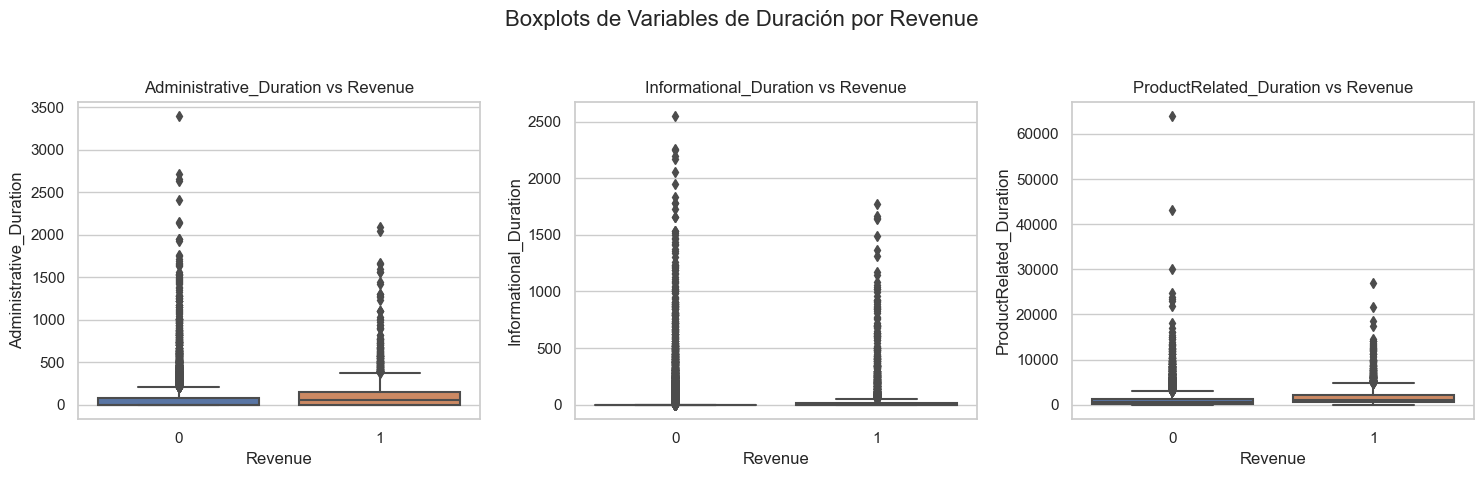

In [19]:
# Lo mismo con variables de duración, pero en relación a la variable objetivo "Revenue"
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Boxplots de Variables de Duración por Revenue', fontsize=16)

for i, col in enumerate(duration_variables):
    ax = axes[i]
    sns.boxplot(x='Revenue', y=col, data=df_clean, ax=ax)
    ax.set_title(f'{col} vs Revenue')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Boxplots de Variables de Duración por Revenue

Estos gráficos muestran cómo se relacionan las duraciones con la generación de ingresos ("Revenue").

- Administrative_Duration, Informational_Duration, ProductRelated_Duration:
  Para todas estas variables, las sesiones que generan ingresos tienden a tener duraciones más largas en comparación con las sesiones que no generan ingresos.
  Esto sugiere que un mayor tiempo de permanencia en el sitio está asociado con una mayor probabilidad de generar ingresos.

Interpretación con Sentido de Negocio por número de visitas

- Compromiso del Usuario: Las sesiones que resultan en ingresos muestran un mayor compromiso (menos rebotes, más tiempo en el sitio, mayor número de páginas visitadas). Esto sugiere que mejorar la experiencia del usuario en el sitio podría aumentar las posibilidades de generar ingresos.
- Valor de las Páginas: Las sesiones con altos valores de página están fuertemente correlacionadas con los ingresos. Mejorar o potenciar las páginas clave podría ser una estrategia para aumentar los ingresos.
        
Interpretación con Sentido de Negocio por duración del usuario en las páginas

- Compromiso del Usuario: Estos análisis refuerzan la idea de que un mayor compromiso (tiempo en el sitio) está asociado con una mayor probabilidad de generar ingresos. Las estrategias que fomenten una mayor interacción con la web podrían ser efectivas para aumentar las ventas.
- Foco en Páginas de Productos: Dado que la duración en páginas relacionadas con productos parece ser un factor importante, enfocar esfuerzos en mejorar estas páginas podría resultar beneficioso.

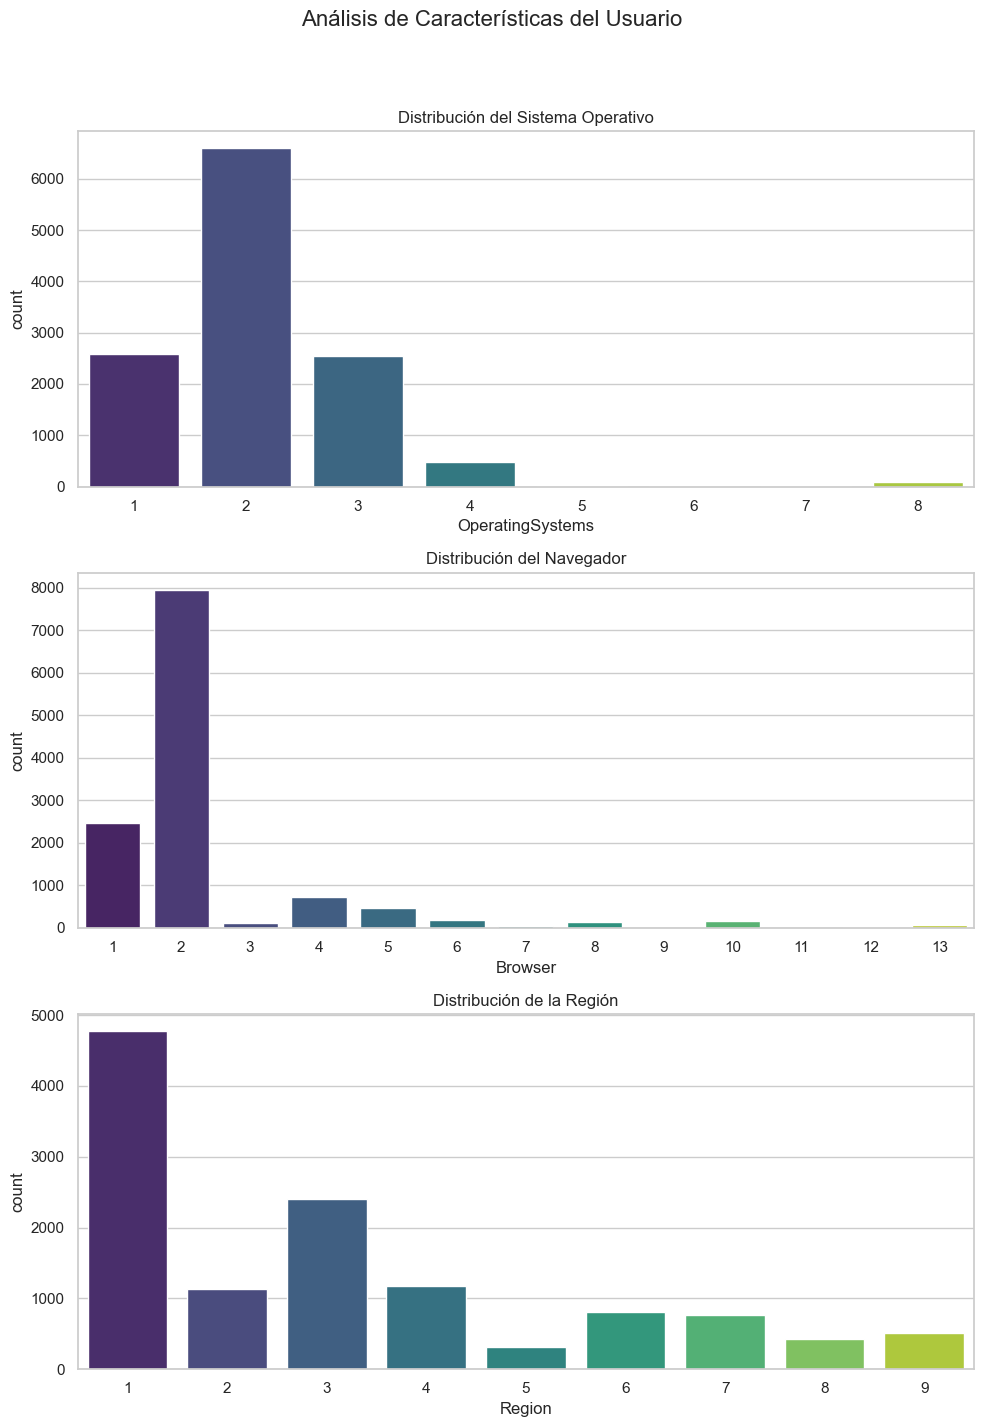

In [20]:
# Creación de gráficos para las características del usuario: Sistema operativo, navegador y región

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle('Análisis de Características del Usuario', fontsize=16)

# Sistema Operativo
sns.countplot(data=df_clean, x='OperatingSystems', ax=axes[0], palette='viridis')
axes[0].set_title('Distribución del Sistema Operativo')

# Navegador
sns.countplot(data=df_clean, x='Browser', ax=axes[1], palette='viridis')
axes[1].set_title('Distribución del Navegador')

# Región
sns.countplot(data=df_clean, x='Region', ax=axes[2], palette='viridis')
axes[2].set_title('Distribución de la Región')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

1. Distribución del Sistema Operativo
    Se observa que hay ciertos sistemas operativos que son mucho más utilizados por los usuarios del sitio web. Esto puede indicar una tendencia o preferencia en el tipo de dispositivos que utilizan los clientes.

2. Distribución del Navegador
    Similar al caso de los sistemas operativos, ciertos navegadores son claramente más populares. Esto puede ser útil para asegurarse de que el sitio web esté optimizado para los navegadores más utilizados.

3. Distribución de la Región
    La distribución por regiones muestra variaciones significativas. Algunas regiones tienen una presencia mucho más alta que otras, lo que podría influir en decisiones de marketing y localización.

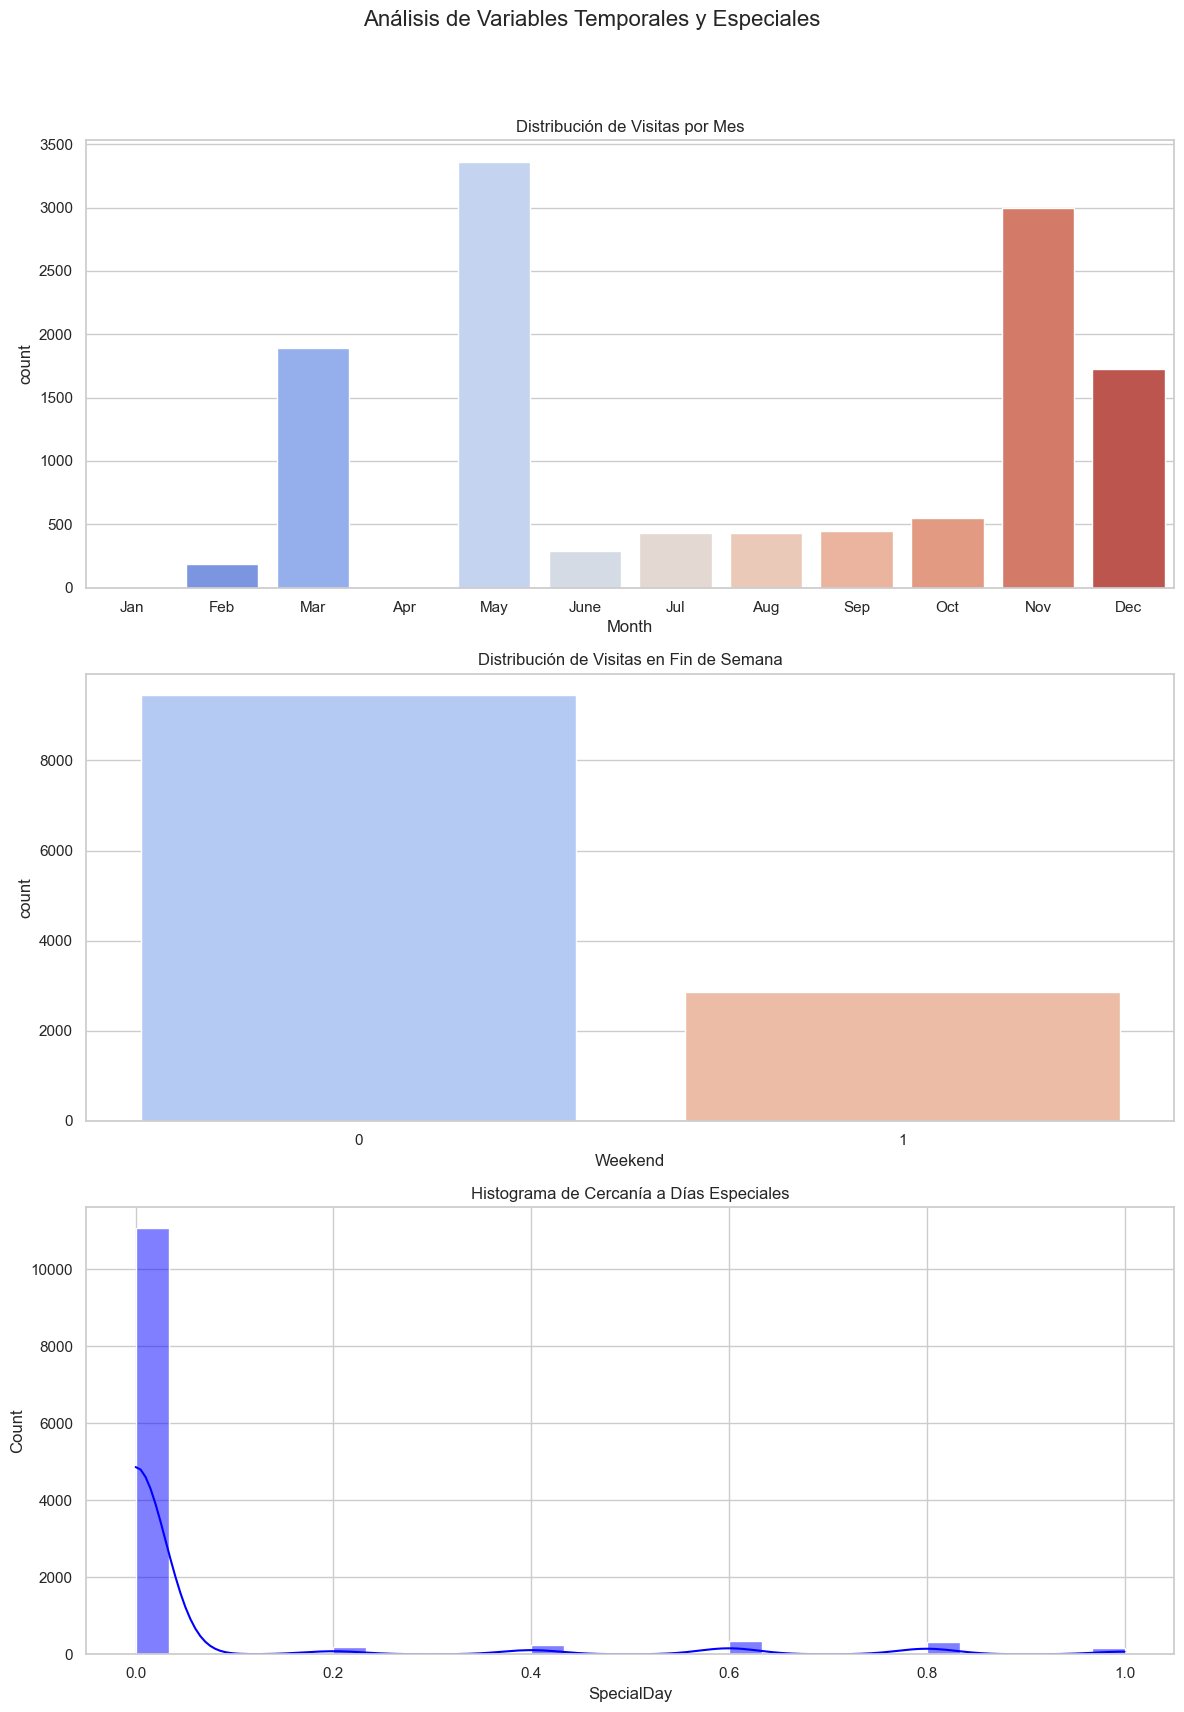

In [21]:
# Análisis de las variables temporales y especiales: Month, Weekend y SpecialDay

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análisis de Variables Temporales y Especiales', fontsize=16)

# Mes de la visita
order_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sns.countplot(data=df_clean, x='Month', ax=axes[0], palette='coolwarm', order=order_months)
axes[0].set_title('Distribución de Visitas por Mes')

# Visitas en fin de semana
sns.countplot(data=df_clean, x='Weekend', ax=axes[1], palette='coolwarm')
axes[1].set_title('Distribución de Visitas en Fin de Semana')

# Cercanía a un Día Especial
sns.histplot(df_clean['SpecialDay'], bins=30, ax=axes[2], kde=True, color='blue')
axes[2].set_title('Histograma de Cercanía a Días Especiales')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Distribución de Visitas por Mes
- La distribución muestra variaciones significativas en el número de visitas a lo largo de los meses. Algunos meses, como noviembre y diciembre, muestran un pico notable en las visitas, lo que puede estar relacionado con temporadas de compras como el Black Friday y la Navidad. La de Mayo, no estoy seguro de por qué es exactamente...

Distribución de Visitas en Fin de Semana
- La comparación entre las visitas durante los fines de semana y los días de semana muestra que hay menos visitas durante los fines de semana. Esto podría influir en la planificación de campañas promocionales.

Histograma de Cercanía a Días Especiales
- La mayoría de las visitas no están cerca de días especiales, lo que se refleja en la concentración de valores cerca de cero. Sin embargo, hay una pequeña cantidad de actividad en torno a días especiales, lo que puede ser relevante para estrategias de marketing enfocadas en estas fechas.

Relevancia para el Negocio
- Planificación de Marketing y Promociones: El análisis temporal puede guiar la planificación de campañas de marketing y promociones, especialmente para aprovechar los meses con mayor tráfico de visitantes.
- Estrategias para Días Especiales: Aunque la mayoría de las visitas no están cerca de días especiales, las estrategias de marketing y ofertas en torno a estas fechas podrían ser una oportunidad para más ventas.

In [22]:
# Columnas a verificar para outliers
columns_to_check = ['Administrative_Duration', 'Informational_Duration', 
                    'ProductRelated_Duration', 'PageValues']

# Detección de outliers
outliers_info = {column: detect_outliers(df_clean, column).shape[0] for column in columns_to_check}
outliers_info

{'Administrative_Duration': 1167,
 'Informational_Duration': 2437,
 'ProductRelated_Duration': 960,
 'PageValues': 2730}

Dado el número de outliers, especialmente en Informational_Duration y PageValues, eliminar estos datos directamente podría no ser la mejor estrategia, ya que representa una gran cantidad de datos. Además, en el contexto del comercio electrónico, estos outliers podrían representar comportamientos de usuario importantes, como clientes muy comprometidos o páginas que son muy valiosas.

## Consideración de Tratamiento de categóricas

In [23]:
df_clean.Month.value_counts()

May     3363
Nov     2998
Mar     1894
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

Estaba planteando hacer REDUCCIÓN DE CATEGORIAS pero procederé al ONE-HOT, se que son 10 categorias nuevas pero no creo sea un problema. Por razones de negocio, no se si es bueno descartar Febrero (San Valentin) o ver si se tiene que estudiar una estrategía de marketing para maximizar ese mes.

In [24]:
df_clean.VisitorType.value_counts()

Returning_Visitor    10537
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

Aunque Returning_Visitor acapara la mayoria, solo son 3 categorias y no creo penalice mucho horizontalmente.

In [25]:
# Aplicación de One-Hot Encoding a las variables categóricas seleccionadas
categorical_vars = ['Month', 'VisitorType', 'OperatingSystems', 'Browser', 'Region']

# Aplicando One-Hot Encoding
df_dummies = pd.get_dummies(df_clean, columns=categorical_vars)

# Mostrando las primeras filas del dataset resultante
df_dummies.head()
df_dummies.shape

(12316, 56)

He añadido más variables al ONE HOT y se han creado muchas variables, entiendo que puede ser "pesado" horizontalmente por lo que voy a ver la correlación y varianza para poder "descartar" variables. Creo que algunas de estas variables "Dummies" pueden dar valor al modelo, sobre todo los meses de más relevancia o las regiones.

In [26]:
corr_matrix = df_dummies.corr(numeric_only=True)
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                          1.000000
PageValues                       0.492494
ProductRelated                   0.158280
Month_Nov                        0.154543
ProductRelated_Duration          0.152130
Administrative                   0.138631
VisitorType_New_Visitor          0.103962
Informational                    0.095085
Administrative_Duration          0.093395
Informational_Duration           0.070250
OperatingSystems_2               0.060115
Month_Oct                        0.032565
Weekend                          0.029293
Browser_13                       0.020937
Month_Sep                        0.019891
Browser_5                        0.016040
Browser_4                        0.015283
Region_1                         0.014467
OperatingSystems_8               0.013384
Browser_10                       0.013251
OperatingSystems_4               0.012720
Browser_12                       0.011430
Month_Aug                        0.010867
Region_2                         0

La matriz de correlación con la variable objetivo "Revenue" muestra lo siguiente:
Positivamente Correlacionadas:
- PageValues: La correlación más alta (0.49), lo que indica que un mayor valor de página está fuertemente asociado con la generación de ingresos.
- ProductRelated, ProductRelated_Duration: Indican una correlación menor pero parece que un mayor número de páginas de productos visitadas y un tiempo más prolongado en ellas pueden influir para bien en la generación de ingresos.
- Administrative, Administrative_Duration: También muestran una correlación positiva, indicando que las actividades administrativas en el sitio pueden tener un impacto en la generación de ingresos.
- Informational, Informational_Duration: Correlaciones más bajas pero aún positivas, lo que sugiere que las páginas informativas también juegan un rol en la generación de ingresos, aunque en menor medida.

Negativamente Correlacionadas:
- BounceRates, ExitRates: Estas variables tienen las correlaciones negativas más significativas, lo que implica que tasas más altas de rebote y salida están asociadas con menores probabilidades de generar ingresos.
- SpecialDay: También tiene una correlación negativa, lo que podría indicar que los días especiales no tienen una gran influencia.

Poca o Ninguna Correlación:
- Variables como Weekend, Browser, TrafficType, Region, OperatingSystems muestran poca o ninguna correlación con "Revenue".

Interpretación con Sentido de Negocio
- Enfocarse en PagrValues: Dado que "PageValues" tiene la correlación más alta, optimizar las páginas para aumentar su valor podría ser una estrategia efectiva para incrementar los ingresos.
- Mejorar la Experiencia del Usuario: Reducir las tasas de rebote y salida puede ser clave, lo que implica mejorar la experiencia de navegación y el contenido del sitio.
- Influencia de Días Especiales: La correlación negativa con "SpecialDay" podría requerir un análisis más detallado para entender cómo los días especiales afectan el comportamiento de compra y ajustar las estrategias de marketing para esos días especiales.

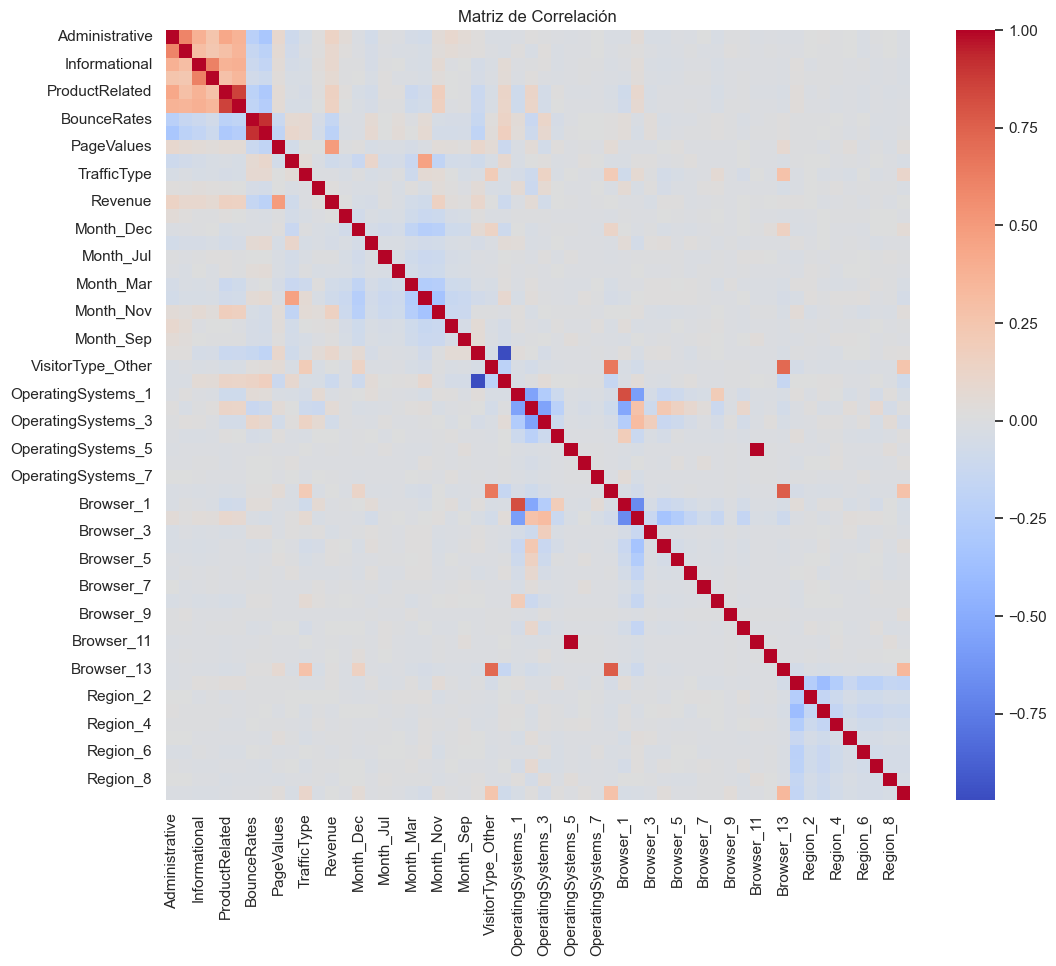

Browser_9             0.000081
Browser_11            0.000487
OperatingSystems_5    0.000487
OperatingSystems_7    0.000568
Browser_12            0.000811
OperatingSystems_6    0.001540
BounceRates           0.002345
ExitRates             0.002355
Browser_7             0.003963
Browser_13            0.004929
OperatingSystems_8    0.006374
VisitorType_Other     0.006855
Browser_3             0.008453
dtype: float64

In [27]:
# Vamos a ver la correlación en una matríz
correlation_matrix = df_dummies.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

# Revisión de la varianza de las variables
variance = df_dummies.var().sort_values()
low_variance = variance[variance < 0.01]  # Umbral de varianza baja

low_variance


In [28]:
def find_correlation(df, thresh=0.75):
    """
    Given a numeric pd.DataFrame, this will find highly correlated features,
    and return a list of features to remove
    params:
    - df : pd.DataFrame
    - thresh : correlation threshold, will remove one of pairs of features with
               a correlation greater than this value
    """
    
    corrMatrix = df.corr()
    corrMatrix.loc[:,:] =  np.tril(corrMatrix, k=-1)

    already_in = set()
    result = []

    for col in corrMatrix:
        perfect_corr = corrMatrix[col][corrMatrix[col] > thresh].index.tolist()
        if perfect_corr and col not in already_in:
            already_in.update(set(perfect_corr))
            perfect_corr.append(col)
            result.append(perfect_corr)


    select_nested = [f[1:] for f in result]
    select_flat = [i for j in select_nested for i in j]
    return select_flat

In [29]:
correlations = [0.9, 0.85, 0.8, 0.75, 0.7, 0.65]

for corr in correlations:
    print("Variables a eliminar con threshold de ", corr, find_correlation(df = df_dummies, thresh = corr))

Variables a eliminar con threshold de  0.9 ['BounceRates', 'OperatingSystems_5']
Variables a eliminar con threshold de  0.85 ['ProductRelated', 'BounceRates', 'OperatingSystems_5']
Variables a eliminar con threshold de  0.8 ['ProductRelated', 'BounceRates', 'OperatingSystems_1', 'OperatingSystems_5']
Variables a eliminar con threshold de  0.75 ['ProductRelated', 'BounceRates', 'OperatingSystems_1', 'OperatingSystems_5', 'OperatingSystems_8']
Variables a eliminar con threshold de  0.7 ['ProductRelated', 'BounceRates', 'VisitorType_Other', 'OperatingSystems_1', 'OperatingSystems_5', 'OperatingSystems_8']
Variables a eliminar con threshold de  0.65 ['ProductRelated', 'BounceRates', 'Browser_13', 'VisitorType_Other', 'OperatingSystems_1', 'OperatingSystems_5']


Voy a eliminar algunas de las variables, SOBRE TODO de las que han surgido de la baja varianza:
- Navegadores y Sistemas Operativos Específicos:
  Variables como Browser_9, Browser_11, Browser_12, Browser_7, Browser_13, OperatingSystems_5,     OperatingSystems_7, OperatingSystems_6, y OperatingSystems_8 tienen varianzas muy bajas. Esto     sugiere que estos navegadores y sistemas operativos no son usados ni populares.

- Otros:
  VisitorType_Other y Browser_3 también presentan baja varianza, lo que indica una baja             variabilidad o baja representación.
  
- BounceRates y ExitRates también aparecen con baja varianza, lo que podría ser indicativo de       valores similares a lo largo de diferentes observaciones. Pero NO las voy a borrar ya que me parece que son variables que dan informción importante sobre el rebote y la salida de los usuarios

In [30]:
# Lista de variables de baja varianza a eliminar, excepto BounceRates y ExitRates
variables_remove = [var for var in low_variance.index if var not in ['BounceRates', 'ExitRates']]

# Eliminación de las variables seleccionadas
df_reduced = df_dummies.drop(columns=variables_remove)

# Mostrando las primeras filas del conjunto de datos después de la eliminación
print(df_reduced.shape)
df_reduced

(12316, 45)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Browser_10,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.000000,0.100000,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.200000,0.200000,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.050000,0.140000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.020000,0.050000,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3.0,145.0,0.0,0.0,53.0,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,1,0,0,0,0,0,0,0,0
12326,0.0,0.0,0.0,0.0,5.0,465.750000,0.000000,0.021333,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
12327,0.0,0.0,0.0,0.0,6.0,184.250000,0.083333,0.086667,0.000000,0.0,...,0,1,0,0,0,0,0,0,0,0
12328,4.0,75.0,0.0,0.0,15.0,346.000000,0.000000,0.021053,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0


Estandarización (Z-score/StandardScaler):
- Transforma los datos para que tengan una media de 0 y una desviación estándar de 1. Es menos sensible a los outliers en comparación con la normalización. Mantiene la estructura de los datos originales (por ejemplo, si había outliers en los datos originales, estos también serán outliers después de la estandarización).

Justificación para la Estandarización:
- Como quiero usar algunos modelos como la regresión logística y las redes neuronales y estos son sensibles a la escala de las características, la estandarización es la opción más adecuada. Además, la estandarización es menos susceptible a los problemas causados por outliers, lo cual es importante dado que hemos visto outliers en los datos.
  Los modelos de árbol, como random forest y XGBoost no son sensibles a la escala de las variables. Sin embargo, aplicar estandarización no les perjudicará y permitirá una mayor coherencia en la preparación de datos a través de los diferentes modelos.

In [31]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12316 entries, 0 to 12329
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Administrative                 12316 non-null  float64
 1   Administrative_Duration        12316 non-null  float64
 2   Informational                  12316 non-null  float64
 3   Informational_Duration         12316 non-null  float64
 4   ProductRelated                 12316 non-null  float64
 5   ProductRelated_Duration        12316 non-null  float64
 6   BounceRates                    12316 non-null  float64
 7   ExitRates                      12316 non-null  float64
 8   PageValues                     12316 non-null  float64
 9   SpecialDay                     12316 non-null  float64
 10  TrafficType                    12316 non-null  int64  
 11  Weekend                        12316 non-null  int32  
 12  Revenue                        12316 non-null 

In [32]:
scaler = StandardScaler()

# Excluimos las columnas binarias generadas por la codificación one-hot y las booleanas
columns_to_scale = df_reduced.select_dtypes(include=['float64', 'int64']).columns

# Estandarizamos las columnas seleccionadas
df_reduced[columns_to_scale] = scaler.fit_transform(df_reduced[columns_to_scale])
df_reduced.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Browser_10,Region_1,Region_2,Region_3,Region_4,Region_5,Region_6,Region_7,Region_8,Region_9
0,-0.697582,-0.457476,-0.396631,-0.245039,-0.691501,-0.624793,3.672627,3.235371,-0.317376,-0.309014,...,0,1,0,0,0,0,0,0,0,0
1,-0.697582,-0.457476,-0.396631,-0.245039,-0.669024,-0.591360,-0.457458,1.174592,-0.317376,-0.309014,...,0,1,0,0,0,0,0,0,0,0
2,-0.697582,-0.463131,-0.396631,-0.252141,-0.691501,-0.625315,3.672627,3.235371,-0.317376,-0.309014,...,0,0,0,0,0,0,0,0,0,1
3,-0.697582,-0.457476,-0.396631,-0.245039,-0.669024,-0.623399,0.575063,1.998904,-0.317376,-0.309014,...,0,0,1,0,0,0,0,0,0,0
4,-0.697582,-0.457476,-0.396631,-0.245039,-0.489202,-0.296996,-0.044449,0.144202,-0.317376,-0.309014,...,0,1,0,0,0,0,0,0,0,0


## Realización de los modelos

In [33]:
df_final = df_reduced

In [34]:
# Dividir el conjunto de datos en características (X) y variable objetivo (y)
X = df_final.drop('Revenue', axis=1)
y = df_final['Revenue']

# Dividir los datos en conjuntos de entrenamiento y prueba (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [35]:
print(u'Dimensiones en train \n-X:{}\n-Y:{}'.format(X_train.shape, y_train.shape))
print(u'Dimensiones en test \n-X:{}\n-Y:{}'.format(X_test.shape, y_test.shape))

Dimensiones en train 
-X:(9237, 44)
-Y:(9237,)
Dimensiones en test 
-X:(3079, 44)
-Y:(3079,)


### Regresión logística

Estamos intentando predecir una variable categórica binaria, que es REVENUE, el SI o NO el cliente a realizado una compra, por lo que al ser una variable categórica tenemos que usar regresión logística.

In [36]:
# Ajusto una regresión logística a Train
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [37]:
# Predigo el conjunto de Test
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test)

In [38]:
print(u'Ejemplo de probabilidad: {}'.format(y_test_prob[:3]))

Ejemplo de probabilidad: [[0.93940347 0.06059653]
 [0.98568878 0.01431122]
 [0.99815932 0.00184068]]


In [39]:
print("Probabilidad ", y_test_prob[0])

#             0          1
# array([0.27280166, 0.72719834])

print("Predicción ", y_test_pred[0])

Probabilidad  [0.93940347 0.06059653]
Predicción  0


In [40]:
print(u'Ejemplo de predicción: {}'.format(y_test_pred[:3]))

Ejemplo de predicción: [0 0 0]


In [41]:
# Obtengo métricas
auc = roc_auc_score(y_test, y_test_prob[:, 1])
auc

0.8943982382567169

In [42]:
print("- Precision:", round(precision_score(y_test, y_test_pred),2))
print("- Recall:", recall_score(y_test, y_test_pred))
print("- Fscore:", round(f1_score(y_test, y_test_pred),2))
print("- AUC:", round(auc,2))
print("- Accuracy ", round(accuracy_score(y_test, y_test_pred), 2))

- Precision: 0.73
- Recall: 0.3530701754385965
- Fscore: 0.47
- AUC: 0.89
- Accuracy  0.88


In [43]:
confusion_matrix(y_test, y_test_pred)

array([[2562,   61],
       [ 295,  161]], dtype=int64)

In [44]:
fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])

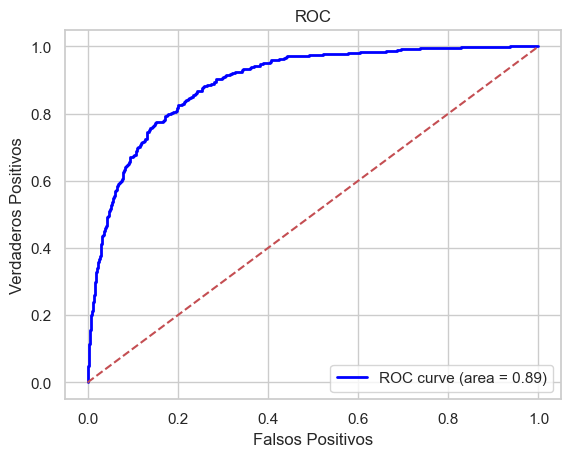

In [45]:
fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.legend(loc="lower right")
plt.show()

Precisión (Precision): 0.73
- La precisión mide la proporción de predicciones positivas correctas (Verdaderos Positivos) entre todas las predicciones positivas realizadas (Verdaderos Positivos + Falsos Positivos). En el modelo, significa que el 73% de las veces que predijo la clase positiva (probablemente en el contexto de 'Revenue' o ingresos), acertó.

Precisión (Accuracy): 0.88
- La precisión mide la proporción de predicciones correctas (tanto positivas como negativas) en comparación con todas las predicciones. Una precisión del 88% indica que el modelo predijo correctamente la clase (positiva o negativa) el 88% del tiempo.
        
Recall: 0.35
- El recall mide la proporción de positivos reales que fueron correctamente identificados por el modelo. Un valor de 0.35 sugiere que el modelo identificó correctamente aproximadamente el 35% de todos los casos positivos reales en los datos.

F-Score: 0.47
- El F-Score es una medida que combina la precisión y el recall en una sola métrica, utilizando su promedio. Un F-Score de 0.47 indica un equilibrio entre precisión y recall, pero sugiere que hay margen de mejora, ya que un valor de 1 sería el ideal.

AUC (Área Bajo la Curva ROC): 0.89
- AUC es una métrica utilizada para evaluar el rendimiento del modelo en todas las tasas de clasificación posibles. Varía entre 0 y 1, donde 1 indica un modelo perfecto. Un AUC de 0.89 es bastante alto, lo que sugiere que el modelo es bastante bueno en distinguir entre las clases positivas y negativas.

### Redes neuronales

Hice uso del modelo visto en clase y sacó buenos resultados. También probé con un modelo que me ofreció ChatGpt, mucho más complejo y que tardó como 8 min en ejecutarse, pero ofreció peores resultados que este más sencillo. Así que más complejo no significa mejor.

In [46]:
# Definimos la estructura del modelo en Keras
input_dim = 44

# Inicializamos el modelo
model = Sequential()

# Definimos la primera capa de entrada con el número de dimensiones y de neuronas de la entrada
model.add(Dense(12, input_dim = input_dim, activation='relu'))

# Definimos la segunda capa oculta intermedia
model.add(Dense(8, activation='relu'))

# Definimos la segunda capa oculta intermedia
model.add(Dense(6, activation='relu'))

# Definimos la segunda capa oculta intermedia
model.add(Dense(4, activation='relu'))

# Definimos la capa de salida
model.add(Dense(1, activation='sigmoid'))

In [47]:
# Compilamos el modelo
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                540       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 6)                 54        
                                                                 
 dense_3 (Dense)             (None, 4)                 28        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 731 (2.86 KB)
Trainable params: 731 (2.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
modelo_multi_layer = model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=1)

Epoch 1/200
924/924 [==============================] - 1s 869us/step - loss: 0.5886 - accuracy: 0.8095
Epoch 2/200
924/924 [==============================] - 1s 863us/step - loss: 0.4180 - accuracy: 0.8858
Epoch 3/200
924/924 [==============================] - 1s 855us/step - loss: 0.3378 - accuracy: 0.8930
Epoch 4/200
924/924 [==============================] - 1s 850us/step - loss: 0.2950 - accuracy: 0.8977
Epoch 5/200
924/924 [==============================] - 1s 924us/step - loss: 0.2724 - accuracy: 0.9041
Epoch 6/200
924/924 [==============================] - 1s 872us/step - loss: 0.2594 - accuracy: 0.9048
Epoch 7/200
924/924 [==============================] - 1s 876us/step - loss: 0.2509 - accuracy: 0.9066
Epoch 8/200
924/924 [==============================] - 1s 909us/step - loss: 0.2457 - accuracy: 0.9067
Epoch 9/200
924/924 [==============================] - 1s 855us/step - loss: 0.2395 - accuracy: 0.9091
Epoch 10/200
924/924 [==============================] - 1s 844us/step - l

924/924 [==============================] - 1s 903us/step - loss: 0.1887 - accuracy: 0.9197
Epoch 80/200
924/924 [==============================] - 1s 885us/step - loss: 0.1892 - accuracy: 0.9191
Epoch 81/200
924/924 [==============================] - 1s 877us/step - loss: 0.1886 - accuracy: 0.9197
Epoch 82/200
924/924 [==============================] - 1s 890us/step - loss: 0.1886 - accuracy: 0.9189
Epoch 83/200
924/924 [==============================] - 1s 905us/step - loss: 0.1894 - accuracy: 0.9189
Epoch 84/200
924/924 [==============================] - 1s 894us/step - loss: 0.1889 - accuracy: 0.9197
Epoch 85/200
924/924 [==============================] - 1s 893us/step - loss: 0.1879 - accuracy: 0.9183
Epoch 86/200
924/924 [==============================] - 1s 897us/step - loss: 0.1876 - accuracy: 0.9204
Epoch 87/200
924/924 [==============================] - 1s 897us/step - loss: 0.1877 - accuracy: 0.9187
Epoch 88/200
924/924 [==============================] - 1s 895us/step - loss:

924/924 [==============================] - 1s 846us/step - loss: 0.1753 - accuracy: 0.9232
Epoch 158/200
924/924 [==============================] - 1s 845us/step - loss: 0.1750 - accuracy: 0.9229
Epoch 159/200
924/924 [==============================] - 1s 846us/step - loss: 0.1735 - accuracy: 0.9231
Epoch 160/200
924/924 [==============================] - 1s 848us/step - loss: 0.1744 - accuracy: 0.9225
Epoch 161/200
924/924 [==============================] - 1s 846us/step - loss: 0.1739 - accuracy: 0.9237
Epoch 162/200
924/924 [==============================] - 1s 839us/step - loss: 0.1741 - accuracy: 0.9231
Epoch 163/200
924/924 [==============================] - 1s 847us/step - loss: 0.1744 - accuracy: 0.9230
Epoch 164/200
924/924 [==============================] - 1s 840us/step - loss: 0.1723 - accuracy: 0.9247
Epoch 165/200
924/924 [==============================] - 1s 838us/step - loss: 0.1732 - accuracy: 0.9237
Epoch 166/200
924/924 [==============================] - 1s 842us/ste

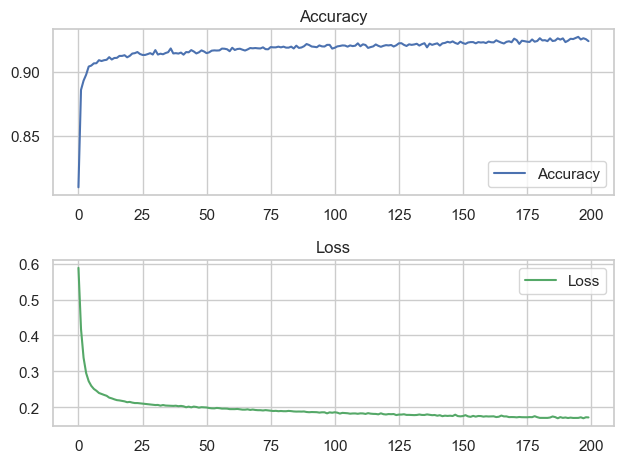

In [50]:
#Plotting metrics
plt.subplot(211)
plt.title("Accuracy")
plt.plot(modelo_multi_layer.history["accuracy"], color="b", label="Accuracy")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(modelo_multi_layer.history["loss"], color="g", label="Loss")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [51]:
model.evaluate(X_train, y_train)

289/289 [==============================] - 0s 680us/step - loss: 0.1614 - accuracy: 0.9289


[0.16138580441474915, 0.9288730025291443]

In [52]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Loss en el conjunto de prueba:", test_loss)
print("Precisión en el conjunto de prueba:", test_accuracy)

97/97 [==============================] - 0s 660us/step - loss: 0.3590 - accuracy: 0.8824
Loss en el conjunto de prueba: 0.35903996229171753
Precisión en el conjunto de prueba: 0.8824293613433838


In [53]:
# Realizar predicciones
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")  # Convertir probabilidades a clases binarias

# Obtener la matriz de confusión
conf_matrix3 = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:\n", conf_matrix3)

# Obtener otras métricas
report = classification_report(y_test, y_pred)
print("Reporte de Clasificación:\n", report)


97/97 [==============================] - 0s 673us/step
Matriz de Confusión:
 [[2467  156]
 [ 206  250]]
Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      2623
           1       0.62      0.55      0.58       456

    accuracy                           0.88      3079
   macro avg       0.77      0.74      0.76      3079
weighted avg       0.88      0.88      0.88      3079



97/97 [==============================] - 0s 558us/step


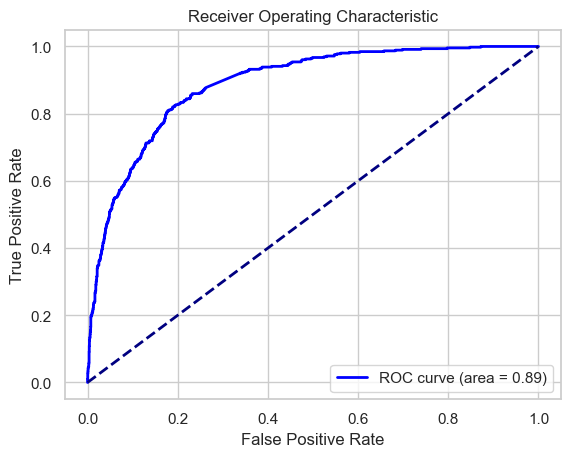

In [54]:
# Genera las predicciones y calcula la tasa de verdaderos y falsos positivos
y_pred_probs = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calcula el área bajo la curva ROC
roc_auc = calc_auc(fpr, tpr)

# Ahora grafica la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Precisión (Precision):
- Para los clientes que no generan ingresos (etiqueta 0), la precisión es del 92%. Esto significa que cuando el modelo dice que un cliente no va a generar ingresos, acierta el 92% de las veces. Para los clientes que sí generan ingresos (etiqueta 1), la precisión es del 62%. Así que, cuando el modelo predice que un cliente va a generar ingresos, acierta la mayoria de veces.

Recall (Sensibilidad):
- De todos los clientes que realmente no generaron ingresos, el modelo los identificó correctamente el 94% de las veces. De los clientes que realmente generaron ingresos, el modelo los identificó correctamente en el 55% de los casos. Esto significa que casi la mitad de los clientes que realmente generaron ingresos fueron "pasados por alto" o no identificados.

F1-Score:
- Este es un balance entre la precisión y el recall. Para los clientes que no generan ingresos, es bastante alto (0.93), lo que indica un buen equilibrio. Para los clientes que sí generan ingresos, el F1-Score es más bajo (0.58), lo que sugiere que el modelo no está tan equilibrado en esta categoría.

Accuracy (Exactitud):
- La precisión global del modelo es del 89%. Esto significa que, en general, el modelo hace predicciones correctas en el 89% de los casos.

ROC (Área Bajo la Curva ROC):
- Un ROC de 0.89 es bastante bueno. Esta métrica mide la habilidad del modelo para distinguir entre las dos clases (clientes que generan y no generan ingresos). Un valor cercano a 1 indica un buen rendimiento.

En resumen, el modelo de redes neuronales es bastante bueno identificando a los clientes que no van a generar ingresos, pero no tan bueno identificando a los que sí. Acierta en la mayoría de las predicciones en general, pero tiende a "pasar por alto" a casi la mitad de los clientes que podrían haber generado ingresos.

### Random Forest

Emplee los mismos parámetros vistos en clase e hice un par de pruebas aplicando cambios, pero siempre me daba como mejores hiperparámetros, los mismos. Por lo que no los cambié más.

In [55]:
rf_model = RandomForestClassifier(random_state=42)

# Parámetros para GridSearch
param_grid_rf = {
    'n_estimators':   [100, 200, 300],  # Número de árboles
    'max_depth':      [5, 10, 20, 30],  # Profundidad máxima de los árboles
    "max_features"  : [10, 20, "sqrt"]
}

# Creando el GridSearch
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, n_jobs=-1, verbose=1)

# Ajustando el modelo
grid_search_rf.fit(X_train, y_train)

# Mejores parámetros y mejor puntuación
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Evaluando el modelo en el conjunto de prueba
y_pred_rf = grid_search_rf.predict(X_test)
y_pred_proba_rf = grid_search_rf.predict_proba(X_test)[:, 1]

# Calculando las métricas
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Imprimiendo los resultados
print("Mejores parámetros:", best_params_rf)
print("Mejor puntuación CV:", best_score_rf)
print("ROC-AUC en test:", roc_auc_rf)
print("Accuracy en test:", accuracy_rf)
print("Recall en test:", recall_rf)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores parámetros: {'max_depth': 10, 'max_features': 20, 'n_estimators': 200}
Mejor puntuación CV: 0.9058139793792203
ROC-AUC en test: 0.9316153995358201
Accuracy en test: 0.9015914257875933
Recall en test: 0.5942982456140351


In [56]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model_rf = grid_search_rf.best_estimator_
predictions_rf = best_model_rf.predict(X_test)

# Imprimir el informe de clasificación
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2623
           1       0.70      0.59      0.64       456

    accuracy                           0.90      3079
   macro avg       0.81      0.77      0.79      3079
weighted avg       0.90      0.90      0.90      3079



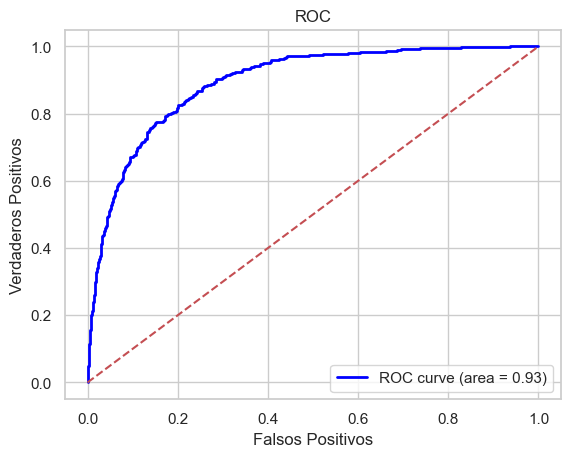

In [57]:
fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], "r--")
plt.title("ROC")
plt.xlabel("Falsos Positivos")
plt.ylabel("Verdaderos Positivos")
plt.legend(loc="lower right")
plt.show()

In [58]:
# Generando las predicciones del modelo
y_pred_rf = grid_search_rf.predict(X_test)

# Calculando la matriz de confusión
conf_matrix2 = confusion_matrix(y_test, y_pred_rf)
conf_matrix2

array([[2505,  118],
       [ 185,  271]], dtype=int64)

In [59]:
# Calcular la rentabilidad para XGBoost
rentabilidad_rf = calcular_rentabilidad(best_model_rf, X_test, y_test)
print(f"Rentabilidad de Random Forest: {rentabilidad_rf} €")

Rentabilidad de Random Forest: 182740 €


Precisión (Precision):
- Para los clientes que no generan ingresos (etiqueta 0), la precisión es del 93%. Esto significa que cuando el modelo dice que un cliente no va a generar ingresos, acierta el 93% de las veces. Para los clientes que sí generan ingresos (etiqueta 1), la precisión es del 70%. O sea, cuando el modelo predice que un cliente va a generar ingresos, acierta 7 de cada 10 veces.

Recall (Sensibilidad):
- De todos los clientes que realmente no generaron ingresos, el modelo los identificó correctamente el 96% de las veces. De los clientes que realmente generaron ingresos, el modelo los identificó correctamente en el 59% de los casos.

F1-Score:
- Para los clientes que no generan ingresos, el F1-Score es alto (0.94), mostrando un buen equilibrio entre precisión y recall. Para los clientes que sí generan ingresos, el F1-Score es de 0.64, que es decente, pero indica que hay margen de mejora.

Accuracy (Exactitud):
- La precisión global del modelo es del 90%, lo que indica que en general hace predicciones correctas en el 90% de los casos.

ROC (Área Bajo la Curva ROC):
- Un ROC de 0.93 es excelente. Indica una muy buena capacidad del modelo para distinguir entre clientes que generan y no generan ingresos.


El modelo de Random Forest es muy bueno identificando clientes que no van a generar ingresos y es decentemente bueno identificando a los que sí. Acierta la mayoría de las veces en general. Sin embargo, todavía hay un número considerable de clientes rentables que el modelo no logra identificar. La capacidad del modelo para diferenciar entre los dos tipos de clientes es muy alta, lo que es un punto fuerte de este modelo.

### XGBoost

In [60]:
# Crear el modelo de XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Al igual que en el modelo anterior, hice un par de pruebas con los hiperparámetros pero no había cambios significativos en los resultados.

In [61]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid_xgb = {
    'n_estimators':  [50, 100, 200],
    'max_depth':     [4, 6, 8],
    "eta"          : [0.2, 0.9],
    "lambda"       : [0.2, 0.5, 2.0]
}

# Crear el objeto GridSearchCV
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)

# Ejecutar la búsqueda de hiperparámetros
grid_search_xgb.fit(X_train, y_train)

# Mejores parámetros y mejor puntuación
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print("Mejores parámetros:", best_params_xgb)
print("Mejor puntuación:", best_score_xgb)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros: {'eta': 0.2, 'lambda': 2.0, 'max_depth': 4, 'n_estimators': 50}
Mejor puntuación: 0.904948237108497


In [62]:
# Evaluar el mejor modelo en el conjunto de prueba
best_model_xgb = grid_search_xgb.best_estimator_
predictions_xgb = best_model_xgb.predict(X_test)

# Imprimir el informe de clasificación
print(classification_report(y_test, predictions_xgb))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2623
           1       0.70      0.62      0.65       456

    accuracy                           0.90      3079
   macro avg       0.82      0.78      0.80      3079
weighted avg       0.90      0.90      0.90      3079



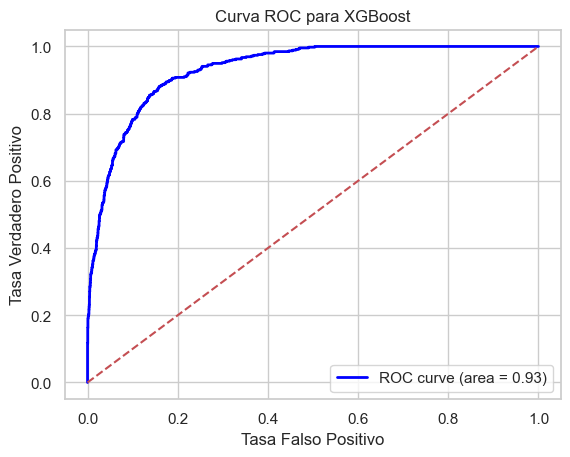

In [63]:
# Predicciones de probabilidad para XGBoost
probs_xgb = best_model_xgb.predict_proba(X_test)
preds_xgb = probs_xgb[:, 1]

# Calcular la curva ROC-AUC para XGBoost
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test, preds_xgb)
roc_auc_xgb = calc_auc(fpr_xgb, tpr_xgb)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], "r--")
plt.title('Curva ROC para XGBoost')
plt.ylabel('Tasa Verdadero Positivo')
plt.xlabel('Tasa Falso Positivo')
plt.legend(loc = 'lower right')
plt.show()

In [64]:
# Matriz de confusión para XGBoost
conf_matrix_xgb = confusion_matrix(y_test, best_model_xgb.predict(X_test))
print(conf_matrix_xgb)

[[2500  123]
 [ 175  281]]


In [65]:
# Calcular la rentabilidad para XGBoost
rentabilidad_xgb = calcular_rentabilidad(best_model_xgb, X_test, y_test)
print(f"Rentabilidad de XGBoost: {rentabilidad_xgb} €")

Rentabilidad de XGBoost: 188140 €


Precisión (Precision):
- Para los clientes que no generan ingresos (etiqueta 0), la precisión es del 93%. Esto significa que casi siempre que el modelo dice que un cliente no va a generar ingresos, está en lo correcto. Para los clientes que sí generan ingresos (etiqueta 1), la precisión es del 70%. Es decir, cuando el modelo predice que un cliente va a generar ingresos, acierta aproximadamente 7 de cada 10 veces.

Recall (Sensibilidad):
- De todos los clientes que realmente no generaron ingresos, el modelo los identificó correctamente el 95% de las veces. De los clientes que realmente generaron ingresos, el modelo los identificó correctamente en el 62% de los casos, lo que significa que casi 4 de cada 10 clientes rentables no fueron detectados por el modelo.

F1-Score:
- Para los clientes que no generan ingresos, el F1-Score es muy alto (0.94), indicando un equilibrio muy bueno entre precisión y recall. Para los clientes que sí generan ingresos, el F1-Score es de 0.65, que es razonable pero muestra que hay margen de mejora en términos de equilibrio entre precisión y recall.

Accuracy (Exactitud):
- La precisión global del modelo es del 90%, lo que significa que en general, el modelo hace predicciones correctas 9 de cada 10 veces.

ROC (Área Bajo la Curva ROC):
- Un ROC de 0.93 es excelente, indicando que el modelo es muy bueno en diferenciar entre clientes que generan y no generan ingresos.

XGBoost está haciendo un buen trabajo. Es muy bueno para identificar a aquellos clientes que no son rentables y también es bastante bueno, aunque no perfecto, en identificar a los rentables. A pesar de su alta precisión general, todavía hay un número significativo de clientes rentables que el modelo no está capturando. La habilidad del modelo para diferenciar entre los dos grupos de clientes es muy alta, lo cual es un punto muy positivo para este modelo.

#### Comparación y Conclusiones entre losque tienen un ROC 0,93, Random Forest y XGBoost ####

Rendimiento General:
- Ambos modelos tienen un rendimiento similar en términos de exactitud y ROC, con un 90% de accuracy y 0.93 en el AUC.

Diferenciación de Clientes Rentables y No Rentables:
- Tanto Random Forest como XGBoost son muy buenos identificando clientes no rentables (con una precisión del 93% y un recall de 96% y 95%, respectivamente).
    Sin embargo, ambos modelos tienen más dificultades para identificar correctamente a los clientes rentables, aunque XGBoost tiene un ligero mejor rendimiento en recall (62% vs 59% de Random Forest).

Balance entre Precisión y Recall (F1-Score):
- El F1-Score para clientes rentables es ligeramente mejor en XGBoost (0.65) comparado con Random Forest (0.64), lo que indica un mejor equilibrio entre precisión y recall en XGBoost.


##### XGBoost tiene un poco más de eficacia en los diferentes parámetros, pero después de ver la rentabilidad de los dos modelos, XGBoost es el ganador absoluto! #####

#### Explicación de cada caso en la matríz de confusión ####

Verdaderos Positivos (TP):
- Estos son los clientes que el modelo ha predicho correctamente que generarían ingresos (realizarían compras) y realmente lo hicieron.
    Estos representan un éxito en la identificación de clientes valiosos.

Falsos Positivos (FP):
- Estos son los clientes que el modelo predijo que generarían ingresos, pero en realidad no lo hicieron.
    Estos casos pueden representar una sobreestimación de las expectativas de ingresos y pueden llevar a decisiones de marketing o de asignación de recursos que no son buenas.

Falsos Negativos (FN):
- Estos son los clientes que el modelo predijo que no generarían ingresos, pero en realidad sí lo hicieron.
    Este grupo podría representar oportunidades perdidas. Son clientes valiosos que el modelo no logró identificar correctamente, lo que podría significar la pérdida de ingresos potenciales o la falta de atención a clientes que podrían haber sido más rentables.

Verdaderos Negativos (TN):
- Estos son los clientes que el modelo predijo correctamente que no generarían ingresos y no lo hicieron.
    En el contexto del negocio, esto significa que el modelo ha identificado correctamente a los clientes que no generan ingresos, lo cual es útil para enfocar los recursos.